# Exploratory Data Analysis
### Purpose
The purpose of this notebook is to explore the Audubon circle and NOAA data.
This notebook addresses some one of the tasks in Github issue #36

### Author: 
Ian Davis
### Date: 
2020-02-17
### Update Date: 
2020-05-03

### Inputs 
1.2-ijd-fetch-circle-elevations_20200502155633.csv - Comma separate file of the Christmas Bird Count and matches to 1 or more NOAA weather stations.
- Data Dictonary can be found here: http://www.audubon.org/sites/default/files/documents/cbc_report_field_definitions_2013.pdf

### Output Files
HTML file report

## Steps or Proceedures in the notebook 
- Set runtime options
    - Set option to retrieve elevations from offline source, or through the USGS queries
    - Set option to only test the USGS query (NOTE: running the query function for the whole dataset will take 24+ hours)
- Create a function to make a remote request to the USGS API
- Create a function to supply inputs to the remote request and return the elevation value
- Main sequence
    - Read in dataset
    - Create circl_elev column
    - Loop through the dataset in chunks of 10000 to get elevation data
    - (Optional) Retrieve elevations from offline data source instead of queries
    - Write new dataset .txt file

## References
- elevation query: https://stackoverflow.com/questions/58350063/obtain-elevation-from-latitude-longitude-coordinates-with-a-simple-python-script
- lamda functions: https://thispointer.com/python-how-to-use-if-else-elif-in-lambda-functions/
- apply on Nulls: https://stackoverflow.com/questions/26614465/python-pandas-apply-function-if-a-column-value-is-not-null

### See data dictionary: 

http://www.audubon.org/sites/default/files/documents/cbc_report_field_definitions_2013.pdf

In [1]:
import numpy as np
import pandas as pd
import plotly_express as px
import matplotlib.pyplot as plt
import datetime
from scipy import stats
import sys

# add scripts folder to path
sys.path.insert(1, '../scripts')

# user import
from calcs import main_calcs

pd.set_option('display.max_columns', 500)

## Set File Paths and Runtime Options

In [2]:
PATH_TO_PAIRED_DATA = '../data/Cloud_data/1.2-ijd-fetch-circle-elevations_20200502155633.csv'

## Read in Data

In [3]:
# Read in unfinished dataset
df_paired = pd.read_csv(PATH_TO_PAIRED_DATA, compression='gzip')

## Calculated Variables

In [4]:
df_paired = main_calcs(df_paired)

## Data Screening

Are there indeces which have negative values for both CBC and NOAA?

In [5]:
df_paired.loc[((df_paired.loc[:, 'min_temp'] < 0.0) & 
               (df_paired.loc[:, 'noaa_tmin_value'] < 0.0))].index.size

1900

Any negative temperatures in Florida?<br>
Lat: 25 to 30<br>
Long: -80 to -90

In [6]:
df_paired.loc[((df_paired.loc[:, 'noaa_tmin_value'] < 0.0) &
               (df_paired.loc[:, 'latitude'] < 30.0) &
               (df_paired.loc[:, 'longitude'] > -90.0))].index.size

0

In [33]:
df_paired.loc[((df_paired.loc[:, 'noaa_tmin_value'] < 0.0) &
               (df_paired.loc[:, 'latitude'] < 30.0) &
               (df_paired.loc[:, 'longitude'] > -90.0)),
               ['noaa_tmin_value', 'circle_name', 'count_date', 'name']].tail(10)

,noaa_tmin_value,circle_name,count_date,name


Create variable(s) to track if CBC recorded precipitation:<br>
- cbc_is_prec
- cbc_is_snow
- cbc_is_rain

- Are there any 'min_snow' values larger than 'max_snow' ?

In [8]:
df_paired.loc[(df_paired.loc[:, 'min_snow'] > df_paired.loc[:, 'max_snow'])].index.size

7

In [9]:
df_paired.loc[(df_paired.loc[:, 'min_snow'] > df_paired.loc[:, 'max_snow']), ['circle_name', 'count_date', 'min_snow', 'max_snow']]

,circle_name,count_date,min_snow,max_snow
80890,Caribou,2011-12-28,4.0,1.0
80910,Presque Isle,2011-12-31,2.0,1.0
81751,Angel Fire-Eagle Nest,2011-12-18,12.0,3.0
83338,Waukesha,2011-12-17,5.0,1.0
83339,Waukesha,2011-12-17,5.0,1.0
83340,Waukesha,2011-12-17,5.0,1.0
83341,Waukesha,2011-12-17,5.0,1.0


In [10]:
# Sometime the rain or snow intensity is listed as "2,1"
# And somewhere along the line these were converted to floats: 32.0 = 3,2 ...probably?
df_paired.loc[:, 'am_rain'].value_counts()

3.0      60171
4.0      21026
2.0       9284
1.0       1344
32.0       716
21.0       636
321.0      239
31.0        19
12.0         6
123.0        1
23.0         1
34.0         1
Name: am_rain, dtype: int64

Rows that contain precipitation values:

In [11]:
df_paired.loc[(df_paired.loc[:, 'cbc_is_prec'] == True)].index.size

94379

In [12]:
# Check for false positives
df_paired.loc[(df_paired.loc[:, 'cbc_is_prec'] == True) &
              (pd.isna(df_paired.loc[:, 'min_snow']) &
               pd.isna(df_paired.loc[:, 'max_snow']) &
               pd.isna(df_paired.loc[:, 'am_rain']) &
               pd.isna(df_paired.loc[:, 'pm_rain'])),
              ['cbc_is_prec', 'min_snow', 'max_snow', 'am_rain', 'pm_rain']].head(10)

,cbc_is_prec,min_snow,max_snow,am_rain,pm_rain


Absolute Temperature Difference:

In [13]:
# What is the maximum temperature difference? Error?
df_paired.loc[df_paired['tmax_diff_abs'] > 100.0]

,int64_field_0,circle_name,country_state,lat,lon,count_year,count_date,n_field_counters,n_feeder_counters,min_field_parties,max_field_parties,field_hours,feeder_hours,nocturnal_hours,field_distance,nocturnal_distance,distance_units,min_temp,max_temp,temp_unit,min_wind,max_wind,wind_unit,min_snow,max_snow,snow_unit,am_cloud,pm_cloud,am_rain,pm_rain,am_snow,pm_snow,field_distance_imperial,field_distance_metric,nocturnal_distance_imperial,nocturnal_distance_metric,min_snow_imperial,min_snow_metric,max_snow_metric,max_snow_imperial,min_temp_imperial,max_temp_imperial,min_temp_metric,max_temp_metric,min_wind_metric,max_wind_metric,min_wind_imperial,max_wind_imperial,geohash_circle,circle_id,id,latitude,longitude,elevation,state,name,gsn_flag,hcn_crn_flag,wmoid,geohash_station,temp_min_value,temp_max_value,precipitation_value,temp_avg,snow,snwd,circle_elev,distance,noaa_tmax_value,noaa_tmin_value,cbc_is_prec,tmin_diff,tmin_diff_abs,tmax_diff,tmax_diff_abs


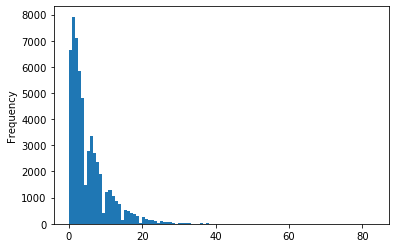

In [14]:
df_paired.loc[:, 'tmin_diff_abs'].plot.hist(bins=100)

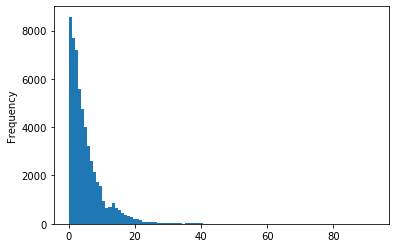

In [15]:
df_paired.loc[:, 'tmax_diff_abs'].plot.hist(bins=100)

Mean temperature difference:

In [16]:
# mean temperature difference
tmin_diff_mean = df_paired.loc[:, 'tmin_diff_abs'].mean(skipna=True)
tmin_diff_std = df_paired.loc[:, 'tmin_diff_abs'].std(skipna=True)
tmax_diff_mean = df_paired.loc[:, 'tmax_diff_abs'].mean(skipna=True)
tmax_diff_std = df_paired.loc[:, 'tmax_diff_abs'].std(skipna=True)

print('Tmin Difference Mean & SD:', round(tmin_diff_mean,2), ', ', round(tmin_diff_std,2))
print('Tmax Difference Mean & SD:', round(tmax_diff_mean,2), ', ', round(tmax_diff_std,2))

Tmin Difference Mean & SD: 5.28 ,  5.52
Tmax Difference Mean & SD: 5.05 ,  5.71


### Outliers



Screen stations further than 10 km:

In [17]:
df_paired_10k = df_paired.loc[(df_paired.loc[:, 'distance'] <= 10000.0), :]
print('Rows in original dataset:', df_paired.index.size)
print('Rows in 10km dataset:', df_paired_10k.index.size)

Rows in original dataset: 109390
Rows in 10km dataset: 55374


Screen stations with obvious temperature errors:<br>
- tmin no less than -100 degF
- tmax no greater than 110 degF
- (probably could be more strict, but this is first guess)

In [18]:
df_paired_10k = df_paired_10k.loc[(df_paired_10k.loc[:, 'min_temp'] > -100.0) &
                                  (df_paired_10k.loc[:, 'noaa_tmin_value'] > -100.0) &
                                  (df_paired_10k.loc[:, 'max_temp'] < 110.0) &
                                  (df_paired_10k.loc[:, 'noaa_tmax_value'] < 110.0), :]
print('Rows in 10km temp-screened dataset:', df_paired_10k.index.size)

Rows in 10km temp-screened dataset: 30236


### ** THAT'S A BIG DROP OFF **

Mean temperature difference:

In [19]:
tmin_diff_mean = df_paired_10k.loc[:, 'tmin_diff_abs'].mean(skipna=True)
tmin_diff_std = df_paired_10k.loc[:, 'tmin_diff_abs'].std(skipna=True)
tmax_diff_mean = df_paired_10k.loc[:, 'tmax_diff_abs'].mean(skipna=True)
tmax_diff_std = df_paired_10k.loc[:, 'tmax_diff_abs'].std(skipna=True)

print('Tmin Difference Mean & SD:', round(tmin_diff_mean,2), ', ', round(tmin_diff_std,2))
print('Tmax Difference Mean & SD:', round(tmax_diff_mean,2), ', ', round(tmax_diff_std,2))

Tmin Difference Mean & SD: 5.07 ,  5.47
Tmax Difference Mean & SD: 4.81 ,  5.6


Box & Whisker Plots:<br>

Tmin & Tmax Difference

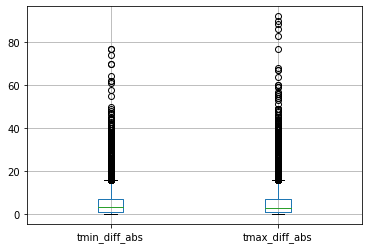

In [20]:
df_paired_10k.boxplot(column=['tmin_diff_abs', 'tmax_diff_abs'])

Clearly, there are some actual errors here. Not just outliers.

In [21]:
df_paired_10k.loc[(df_paired_10k.loc[:, 'tmin_diff_abs'].nlargest(20)).index,
              ['circle_name', 'count_date', 'distance', 'min_temp', 'noaa_tmin_value', 'tmin_diff_abs']]

,circle_name,count_date,distance,min_temp,noaa_tmin_value,tmin_diff_abs
79406,Malibu,2011-12-18,7076.027897,45.0,-32.08,77.08
63823,Santa Cruz Island,2007-12-17,9573.838063,22.0,-54.94,76.94
63679,Crystal Springs,2007-12-15,7299.333140,42.0,-32.08,74.08
60942,Crystal Springs,2006-12-16,7299.333140,38.0,-32.08,70.08
11463,Kaua'i: Kapa'a,1973-12-31,9421.868369,0.0,69.98,69.98
63663,Calaveras,2008-01-05,9483.063229,32.0,-32.08,64.08
60926,Calaveras,2006-12-30,9483.063229,30.0,-32.08,62.08
33794,St. Augustine,1991-12-14,5928.604728,0.0,62.06,62.06
75080,Elsinore,2011-01-02,7544.643135,26.0,87.08,61.08
63355,Holcombe,2006-12-15,8048.504030,86.0,28.04,57.96


Calculate z-scores:

In [22]:
#df_paired.loc[:, 'cbc_tmin_z'] = stats.zscore(df_paired.loc[:, 'min_temp'], nan_policy='omit')
#df_paired.loc[:, 'cbc_tmax_z'] = stats.zscore(df_paired.loc[:, 'max_temp'])
#df_paired.loc[:, 'noaa_tmin_z'] = stats.zscore(df_paired.loc[:, 'noaa_tmin_value'])
#df_paired.loc[:, 'noaa_tmax_z'] = stats.zscore(df_paired.loc[:, 'noaa_tmax_value'])
df_paired_10k.loc[:, 'tmin_diff_z'] = stats.zscore(df_paired_10k.loc[:, 'tmin_diff_abs'], nan_policy='omit')
df_paired_10k.loc[:, 'tmax_diff_z'] = stats.zscore(df_paired_10k.loc[:, 'tmax_diff_abs'], nan_policy='omit')

In [23]:
df_paired_10k.loc[:, 'tmin_diff_z'].head(10)

7082   -0.735760
7086    0.890521
7090   -0.549377
7091    1.084213
7093   -0.571305
7097   -0.567650
7098    0.170572
7100   -0.922143
7101   -0.914834
7103    2.184237
Name: tmin_diff_z, dtype: float64

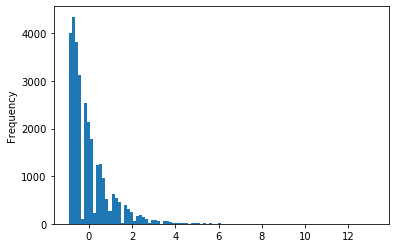

In [24]:
df_paired_10k.loc[:, 'tmin_diff_z'].plot.hist(bins=100)

Eliminate outliers (z > 2.96):

In [25]:
df_paired_noout = df_paired_10k.loc[((df_paired_10k.loc[:, 'tmin_diff_z'].abs() < 2.96) &
                                     (df_paired_10k.loc[:, 'tmax_diff_z'].abs() < 2.96))]

print('Rows in 10km temp-screened dataset:', df_paired_10k.index.size)
print('Rows in no outlier dataset:', df_paired_noout.index.size)

Rows in 10km temp-screened dataset: 30236
Rows in no outlier dataset: 29281


Show box & whisker plots again:

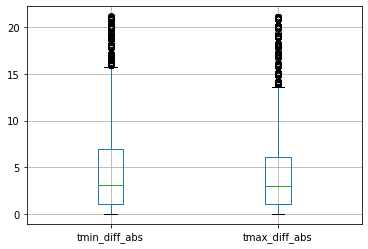

In [26]:
df_paired_noout.boxplot(column=['tmin_diff_abs', 'tmax_diff_abs'])

### Counting:<br>

Unique station count:

In [27]:
df_paired.loc[:, 'id'].value_counts()
station_list = df_paired.loc[:, 'id'].unique()
len(station_list)

11652

Total rows:

In [28]:
df_paired.index.size

109390

Rows with closest stations under 10 km:

In [29]:
df_paired_10k.index.size

30236

Histogram of station distances:

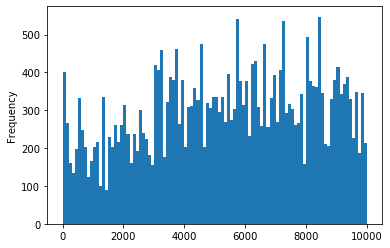

In [30]:
df_paired_10k.loc[:, 'distance'].plot.hist(bins=100)

Scatter plot of station distance with mean temperature difference:

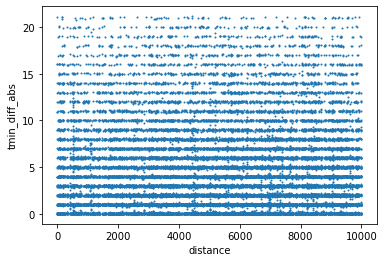

In [31]:
df_paired_noout.plot.scatter(x='distance',
                             y='tmin_diff_abs',
                             s=1)

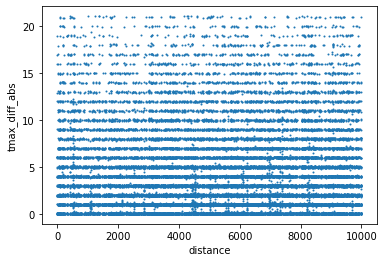

In [32]:
df_paired_noout.plot.scatter(x='distance',
                             y='tmax_diff_abs',
                             s=1)